In [3]:
import tensorflow as tf
import numpy as np
import os 
import cv2
import random
from tqdm import tqdm
from tensorflow.keras.layers import LSTM, Bidirectional, Conv2D, Dense, Flatten, MaxPooling2D, TimeDistributed, Reshape
from tensorflow.keras.models import Sequential
import time
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import shuffle
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers

In [4]:
LR = 0.0001
BATCH_SIZE = 64
MOMENTUM = 0.9
IMG_SIZE = 224
EPOCHS = 5

TRAIN_DIR = './Peliculas/Data/train/'
TEST_DIR = './Peliculas/Data/valid/'

In [17]:
TRAIN_DATA = []
for folder in os.listdir(TRAIN_DIR):
    for files in tqdm(os.listdir(os.path.join(TRAIN_DIR, folder))):
        path = os.path.join(os.path.join(TRAIN_DIR, folder), files)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        if folder == 'fight':
            TRAIN_DATA.append([np.array(image), [1, 0]])
        elif folder == 'nofight':
            TRAIN_DATA.append([np.array(image), [0, 1]])

shuffle(TRAIN_DATA)
np.save('movie_training_data.npy', TRAIN_DATA)

100%|██████████| 4410/4410 [00:18<00:00, 243.31it/s]


In [18]:
TEST_DATA = []
for folder in os.listdir(TEST_DIR):
    for files in tqdm(os.listdir(os.path.join(TEST_DIR, folder))):
        path = os.path.join(os.path.join(TEST_DIR, folder), files)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        if folder == 'fight':
            TEST_DATA.append([np.array(image), [1, 0]])
        elif folder == 'nofight':
            TEST_DATA.append([np.array(image), [0, 1]])

shuffle(TEST_DATA)
np.save('movie_testing_data.npy', TEST_DATA)

100%|██████████| 539/539 [00:01<00:00, 274.18it/s]


In [3]:
def create_dataset():
    dataset = []
    limit = 0


    for file in tqdm(os.listdir('./Peliculas/Dataframes/')):
        path = os.path.join('./Peliculas/Dataframes/', file)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        if limit < 4791:
            dataset.append([image, np.array([1, 0])])
        elif limit >= 4791:
            dataset.append([image, np.array([0, 1])])
        
        limit += 1 
            
    
    shuffle(dataset)
    np.save('movie_data.npy', dataset)
    return dataset

In [4]:
data = create_dataset()

100%|██████████| 9841/9841 [01:10<00:00, 140.10it/s]
C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [3]:
data = np.load('movie_data.npy', allow_pickle=True)

In [4]:
data[0][1]

array([0, 1])

In [15]:
DATA_SET = [] 
#for folders in os.listdir('./Peliculas/Data/'+str(folders)): 
folder_path = './Peliculas/Videos/' 
for files in tqdm(os.listdir(folder_path)):     
    print(files)     
    path = os.path.join(folder_path, files)     
    print(path)     
    for a in os.listdir(path):  
        paths= os.path.join(path,a)         
        image = cv2.resize(cv2.imread(paths), (IMG_SIZE, IMG_SIZE))

        if files == 'fight':
            DATA_SET.append([np.array(image), [1, 0]])         
        elif files == 'nofight':             
            DATA_SET.append([np.array(image), [0, 1]])  
            
shuffle(DATA_SET) 
np.save('movie_data_1.npy', DATA_SET)

  0%|          | 0/2 [00:00<?, ?it/s]fights
./Peliculas/Videos/fights



error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6lylwdcz\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [5]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dense(2, activation='sigmoid'))

model = add_model
model.compile(loss='categorical_crossentropy', optimizer = optimizers.SGD(lr=LR, momentum = 0.9), metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
kf = KFold(10)

X = np.array([i[0] for i in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = np.array([i[1] for i in data])
X = X.astype('float32')/255
fold = 0

for train, test in kf.split(data):
    fold += 1
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]

    Model_name = 'movie-model-fold' + str(fold)
    tensorboard = TensorBoard(log_dir='logs/{}'.format(Model_name))


    model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose = 1, epochs= 5, batch_size=64, callbacks=[tensorboard])
    #Model_name = 'movie-model-fold' + str(fold) + '.h5'
    #weights_name = 'movie-weight-fold' + str(fold) + '.h5'
model.save('movie-model-sigmoid-main.h5', overwrite = True, include_optimizer = True)
    #model.save_weights(weights_name, overwrite=True)

Epoch 1/5
139/139 [==============================] - 41s 209ms/step - loss: 0.6849 - accuracy: 0.5933 - val_loss: 0.4536 - val_accuracy: 0.8010
Epoch 2/5
139/139 [==============================] - 25s 183ms/step - loss: 0.4376 - accuracy: 0.8162 - val_loss: 0.3775 - val_accuracy: 0.8528
Epoch 3/5
139/139 [==============================] - 26s 184ms/step - loss: 0.3735 - accuracy: 0.8476 - val_loss: 0.3400 - val_accuracy: 0.8690
Epoch 4/5
139/139 [==============================] - 26s 186ms/step - loss: 0.3470 - accuracy: 0.8579 - val_loss: 0.3146 - val_accuracy: 0.8751
Epoch 5/5
139/139 [==============================] - 26s 185ms/step - loss: 0.3312 - accuracy: 0.8643 - val_loss: 0.2960 - val_accuracy: 0.8873
Epoch 1/5
139/139 [==============================] - 27s 192ms/step - loss: 0.2939 - accuracy: 0.8813 - val_loss: 0.3016 - val_accuracy: 0.8679
Epoch 2/5
139/139 [==============================] - 26s 186ms/step - loss: 0.2797 - accuracy: 0.8873 - val_loss: 0.2881 - val_accuracy:

In [16]:
model.evaluate(x = X, y =Y, batch_size= 5, verbose = 1)

1969/1969 [==============================] - 69s 33ms/step - loss: 0.1393 - accuracy: 0.9582


[0.13925674557685852, 0.9582359790802002]

In [6]:
X = np.array([i[0] for i in data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = np.array([i[1] for i in data])

In [7]:
X = X.astype('float32')/255

In [17]:
model_tf = load_model('./movie-model-softmax2.h5')
model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
model_tf.evaluate(x = X, y =Y, batch_size= 5, verbose = 1)

1969/1969 [==============================] - 65s 32ms/step - loss: 0.1444 - accuracy: 0.9525


[0.14441141486167908, 0.9525454640388489]

# Predictions


In [2]:
test_frame_folder_path = './Test_movie/'

In [3]:
data = []
c = 0
for files in os.listdir(test_frame_folder_path):
    path = os.path.join(test_frame_folder_path, files)
    image = cv2.resize(cv2.imread(path), (224, 224))
    if c < 5:
        data.append([np.array(image), [1, 0]])
    if c >= 5:
        data.append([np.array(image), [0, 1]])
    c += 1

In [4]:
np.asarray(data).shape

C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(10, 2)

In [5]:
X = np.array([i[0] for i in data]).reshape(-1, 224, 224, 3)
Y = np.array([i[1] for i in data])

In [6]:
model_tf = load_model('./movie-model-softmax2.h5')

In [9]:
model_tf.predict(X, verbose= 1)

1/1 [==============================] - 8s 8s/step


array([[1.0000000e+00, 8.8638336e-24],
       [5.1665790e-02, 9.4833422e-01],
       [1.0000000e+00, 1.8207745e-38],
       [1.0000000e+00, 0.0000000e+00],
       [3.3298443e-07, 9.9999964e-01],
       [1.0000000e+00, 4.2389284e-20],
       [3.4294343e-01, 6.5705657e-01],
       [9.0852958e-01, 9.1470435e-02],
       [9.9999988e-01, 9.0996878e-08],
       [1.0000000e+00, 1.8135871e-22]], dtype=float32)

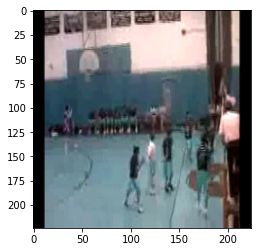

In [17]:
plt.imshow(X[9])